# Week of 2025.07.30

## Goal of this week:
- [ ] Create clean visulizations that show the current state of the infrasound work.
- [ ] Coordinate meeting with Fred + Mario + Eric to discuss the current state of things and figure out what needs to further be worked on.
- [ ] Get Fred's lightpath data to verify methods for calculating pressure at observer
- [ ] Put together slide show. 
- [x] Get access from to `/oak/stanford/groups/edunham`


## Things to change
- Plot mach numbers 
- Color bar of atmosphere + plot heat 
- Add atmosphere temperature plot.
- Reduce stem to maybe 10 m
- time series of flank of volcano. 

## Notes 
- public wifi can block ssh access. 

## Sherlock notes
- Jupyter notebooks can be run via [interactive sessions](https://ondemand.sherlock.stanford.edu/pun/sys/dashboard/batch_connect/sessions)
- In theory there is a way to ssh onto sherlock via VS code like [this](https://www.sherlock.stanford.edu/docs/storage/data-transfer/#sshfs). That appeals to me because it means I could run a simulation and visualize locally on vs code but have all the data live on sherlock. 

## Questions 
- Once you start a job on sherlock how the heck do you check its progress? 

In [1]:
%load_ext autoreload
%autoreload 2

from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func, get_quantities_at_conduit_exit, get_quantities_at_all_space
from helper_code.animate import animate_conduit_pressure, animate_melt_atmosphere_combination
from helper_code.analytical_solution import get_lumped_solution

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

folder_name = "simple_conduit"

ITERS = 50
D_ITERS = 1
END_TIME = 10
C0 = 320 # m/s at 5000m

## 0.0 Velocity & Pressure at outlet of various runs

In [2]:
file_name = "tungurahua_no_atm_v0"
folder_name = "2025_07_21_eruption_sim"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_tung_no_atm, p_tung_no_atm, slip_tung_no_atm, u_tung_no_atm, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "tungurahua_atm_1m"
folder_name = "2025_07_21_eruption_sim"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_tung_atm_1m, p_tung_atm_1m, slip_tung_atm_1m, u_tung_atm_1m, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

folder_name = "2025_07_23_eruption_1d_atmosphere_sim"
file_name = "tungurahua_atm_1m"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_tung_atm_1m_1d, p_tung_atm_1m_1d, slip_tung_atm_1m_1d, u_tung_atm_1m_1d, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

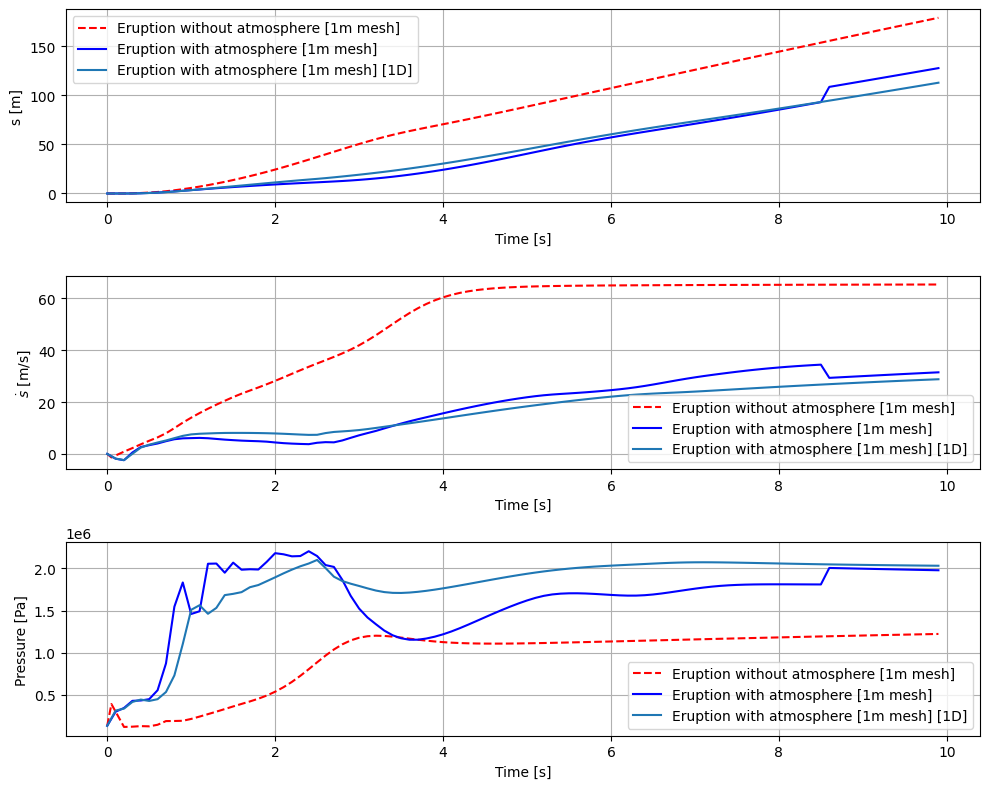

In [3]:
# Plot results
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(t_tung_no_atm, slip_tung_no_atm, "r--", label="Eruption without atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m, slip_tung_atm_1m, "b-", label="Eruption with atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m_1d, slip_tung_atm_1m_1d, label="Eruption with atmosphere [1m mesh] [1D]")
plt.xlabel("Time [s]")
plt.ylabel("s [m]")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_tung_no_atm, u_tung_no_atm, "r--", label="Eruption without atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m, u_tung_atm_1m, "b-", label="Eruption with atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m_1d, u_tung_atm_1m_1d, label="Eruption with atmosphere [1m mesh] [1D]")
plt.xlabel("Time [s]")
plt.ylabel(r"$\dot{s}$ [m/s]")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_tung_no_atm, p_tung_no_atm, "r--", label="Eruption without atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m, p_tung_atm_1m, "b-", label="Eruption with atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m_1d, p_tung_atm_1m_1d, label="Eruption with atmosphere [1m mesh] [1D]")
plt.xlabel("Time [s]")
plt.ylabel("Pressure [Pa]")
plt.grid(True)
plt.legend()

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/fred_presentation/slip_pressure_slip_dot.png", dpi=300)
plt.tight_layout()
plt.show()

## 1.0 Eruption paired with **1D** atmosphere

In [ ]:
folder_name = "2025_07_23_eruption_1d_atmosphere_sim"
melt_file_name = "tungurahua_atm_1m"
atmosphere_file_name = "vertical_atmosphere_01_atm1"
melt_solver_func = get_local_solver_from_index_func(folder_name, melt_file_name)
atmosphere_solver_func = get_local_solver_from_index_func(folder_name, atmosphere_file_name)

iters = 100

ani = animate_melt_atmosphere_combination(
    melt_solver_func,
    atmosphere_solver_func,
    iterations=100,
    d_iterations=1,
    y_min=-1000,
    y_max=1000,
    max_pressure=0.13,
    min_pressure=0.07,
    max_velocity=100,
    min_velocity=0,
    max_density=3e3,
    min_density=0,
    max_slip=150,
    min_slip=0,
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/fred_presentation/1d_atmosphere_combination.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)

HTML(ani.to_html5_video())


## 2.0 Eruption paired with **2D** atmosphere

### 2.1 Melt

In [ ]:
file_name = "tungurahua_no_atm_v0"
folder_name = "2025_07_21_eruption_sim"
iters = 100
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=iters,
    d_iterations=1,
    viscosity_index=1,
    wall_friction_index=5,
    max_velocity=20,
    max_slip=60,
    max_tau=1.5,
    max_pressure=25,
    max_speed_of_sound=2000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=2,
)

HTML(ani.to_html5_video())

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/fred_presentation/conduit_flow_connected_2D_atmosphere.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)

### 2.2 Atmosphere
- Time elapsed for me to run this simulation locally: 10hr?

In [ ]:
from helper_code.atmosphere_animate import atmosphere_2d_animate

folder_name = "2025_07_21_eruption_sim"
file_name = "test_infrasound_v1_atm1"
iterations = 80

ani = atmosphere_2d_animate(
    iterations=iterations,
    d_iter=4,
    folder=folder_name,
    file_name=file_name
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/fred_presentation/2d_atmosphere.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)

HTML(ani.to_html5_video())

### 2.1 Time Series Pressure Data


In [ ]:
import matplotlib.tri as tri
from helper_code.infrasound import *

folder_name = "2025_07_21_eruption_sim"
file_name = "test_infrasound_v1_atm1"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
iterations = 80

solver_0 = solver_func(0)

triangulation = tri.Triangulation(solver_0.mesh.node_coords[...,0],
                  solver_0.mesh.node_coords[...,1], 
                  triangles=solver_0.mesh.elem_to_node_IDs)

trifinder = triangulation.get_trifinder()

p_20 = infrasound.get_p_series(20, 0, solver_func, trifinder, iterations=iterations, p0=1e5)
p_50 = infrasound.get_p_series(50, 0, solver_func, trifinder, iterations=iterations, p0=1e5)
p_80 = infrasound.get_p_series(80, 0, solver_func, trifinder, iterations=iterations, p0=1e5)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), sharex=True)
t_end = solver_func(iterations-1).time
t = np.linspace(0, t_end, len(p_20))
C0 = 320

axes[0].plot(t, p_20, label="pressure a r=20")
axes[1].plot(t, p_50, label="pressure at r=50")
axes[2].plot(t, p_80, label="pressure at r=80")


for i, ax in enumerate(axes):
    ax.legend(loc='lower right')
    ax.grid(True)
    ax.set_ylim(-200, 200)  
    ax.set_xlim(0, t_end)

fig.suptitle("Pressure at various radi")
fig.supylabel("pressure (Pa)")
fig.supxlabel("time (s)")

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/fred_presentation/pressure_atm_time_series.png", dpi=300)
plt.tight_layout()
plt.show()

## 3.0 Light hill stress tensor

### 3.1 Accoustic pressure calculate as volume intergral

I am calculating the volume integral over the half-cylindrical region bounded by $r < 80 $ and $y > -80$ and $y<80$. 

As we can see in the above graphics, the value of the double divergence of the  lighthill stress tensor falls off outside those bounds. 

The equation we solve below is:

$$
p'(x,t) = \frac{1}{4\pi} \int_v \frac{1}{|x - y|} \frac{\partial^2 T_{ij}}{\partial y_i \partial y_j} (y, t - \frac{|x-y|}{c_0}) dy^3
$$

To solve for pressure as a time series, we can just iterate over the integral for all time steps. We need only calculate the value of $\frac{\partial^2 T_{ij}}{\partial y_i \partial y_j}$ when $t - \frac{|x-y|}{c_0}$ is greater than 0 and less than the end of the simulation. 

- [ ] The $4 \pi$ in the denominator is technically incorrect for our geometry. 

My implementation can be found [here](http://github.com/paxtonsc/volcano-sims/blob/main/notebooks/helper_code/lighthill.py#L78). Validation for that implementation can be found in [section 3.1 here](https://paxtonsc.github.io/files/geophysics/volcano_project/weekly_notes/2025.05.20.experiments.html). 

In [ ]:
import helper_code.lighthill as lighthill
import numpy as np
import matplotlib.tri as tri

iterations = 80

def solver_from_2D(dom, i):
    solver_func = get_local_solver_from_index_func("2025_07_21_eruption_sim", f"test_infrasound_v1_atm{dom}")

    return solver_func(i)

# Prep interpolation grid
solver0 = solver_from_2D(1, 0)
physics = solver0.physics
base_x = np.linspace(0, 125, 200)
base_y = np.linspace(-125, 125, 200)
mg_x, mg_y = np.meshgrid(base_x, base_y, indexing="xy")

solver0_list = [solver_from_2D(dom_idx, 0) for dom_idx in [1]]
# Compute workload partition
ind_partition = [np.where(tri.Triangulation(
  solver.mesh.node_coords[...,0],
  solver.mesh.node_coords[...,1], 
  triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(mg_x.ravel(), mg_y.ravel()) != -1)[0]
  for solver in solver0_list]

# List of file indices to read
file_index_list = np.arange(0,iterations,1)

In [ ]:
# Allocate union (joining all times) U, in spatially-flattened shape
U_union = np.nan * np.empty((file_index_list.size, *mg_x.ravel().shape, 8+physics.NDIMS))

for time_idx, file_idx in enumerate(file_index_list):

	# Load solvers for given time_idx
	solver_list = [solver_from_2D(dom_idx, file_idx) for dom_idx in [1]]

	for solver, _index_partition in zip(solver_list, ind_partition):
		# Identify physical position (x, y) of points to interpolate at with shape (npoints, 2)
		_phys_pos = np.stack(
			(mg_x.ravel()[_index_partition],
			mg_y.ravel()[_index_partition]),
			axis=1)
		# Identify element indices for all points to interpolate at
		elt_indices = tri.Triangulation(
			solver.mesh.node_coords[...,0],
			solver.mesh.node_coords[...,1], 
			triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(_phys_pos[:,0], _phys_pos[:,1])

		# Identify element node coordinates
		x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
		# Compute global physical-to-reference coordinate mapping
		ref_mapping = lighthill.compute_ref_mapping(x_tri)

		# Interpolate for each point using the correct element, writing to correct index in global U array
		for (write_idx, x_point, ie) in zip(_index_partition, _phys_pos, elt_indices):
			# For element containing point, compute reference coordinate of sampling point
			ref_coords_loc = np.einsum("ij, j -> i",
																ref_mapping[ie,...],
																x_point - x_tri[ie,0,:])
			# Evaluate basis at reference coordinate
			#U_union[time_idx,write_idx,:] = (solver.state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]))

            # I believe this is the correct calculation for order 1
			U_union[time_idx,write_idx,:] = (solver.state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]) + solver.state_coeffs[ie,1,:] * ref_coords_loc[0] + solver.state_coeffs[ie,2,:] * ref_coords_loc[1])

In [ ]:
# Evaluate temperature using interpolated state, migrate to meshgrid shape (time_indices, mg_x.shape[0], mg_x.shape[1])
T_interp = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
yM = np.reshape(U_union[...,2:3] / rho, (file_index_list.size, *mg_x.shape))

t_range = np.linspace(0, solver_from_2D(1, iterations-1).time, T_interp.shape[0])

In [ ]:
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
u = U_union[:,:,3:4] / rho
v = U_union[:,:,4:5] / rho

# Pull rho, u, v
mg_u = np.reshape(u, (file_index_list.size, *mg_x.shape))
mg_v = np.reshape(v, (file_index_list.size, *mg_x.shape))
mg_T = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p = np.reshape(physics.compute_variable("Pressure", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_rho = np.reshape(rho, (file_index_list.size, *mg_x.shape))
mg_c = np.reshape(physics.compute_variable("SoundSpeed", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p0 = mg_p[0,...]

In [ ]:
# Grid dimensions
dx = np.diff(mg_x[0:1,:], axis=1)
dy = np.diff(mg_y[:,0:1], axis=0)
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]

# Grid-center differentiation
u_foldx = (0.5 * (mg_u[:,:,1:] + mg_u[:,:,:-1]))
u_foldy = (0.5 * (mg_u[:,1:,:] + mg_u[:,:-1,:]))
dudy = np.diff(u_foldx, axis=1) / dy
dudx = np.diff(u_foldy, axis=2) / dx

v_foldx = (0.5 * (mg_v[:,:,1:] + mg_v[:,:,:-1]))
v_foldy = (0.5 * (mg_v[:,1:,:] + mg_v[:,:-1,:]))
dvdy = np.diff(v_foldx, axis=1) / dy
dvdx = np.diff(v_foldy, axis=2) / dx

mg_c0 = mg_c[0,...]
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]
# Interior grid-center coordinates
int_x = center_x[1:-1,1:-1]
int_y = center_y[1:-1,1:-1]

In [ ]:
# Evaluate matrix T
T00_nonlinear = mg_p - mg_c0*mg_c0 * mg_rho
T01_nonlinear = np.zeros_like(mg_rho)
T10_nonlinear = np.zeros_like(mg_rho)
T11_nonlinear = mg_p - mg_c0*mg_c0 * mg_rho

# Mixed derivative (symmetric)
d2T01 = (np.diff(np.diff(T01_nonlinear, axis=-1), axis=-2) / dx) / dy

# d^2(T00)/dx^2
T00_foldy = 0.5 * (T00_nonlinear[:,1:,:] + T00_nonlinear[:,:-1,:])
d2T00 = T00_foldy[:,:,3:] - T00_foldy[:,:,2:-1] - T00_foldy[:,:,1:-2] + T00_foldy[:,:,0:-3]
# d^2(T11)/dy^2
T11_foldx = 0.5 * (T11_nonlinear[:,:,1:] + T11_nonlinear[:,:,:-1])
d2T11 = T11_foldx[:,3:,:] - T11_foldx[:,2:-1,:] - T11_foldx[:,1:-2,:] + T11_foldx[:,0:-3,:]

# Evaluate Lighthill analogy source at cell center, for interior cells (discard boundary cells)
dijTij_nonlinear = d2T00[:,1:-1,:] + 2 * d2T01[:,1:-1,1:-1] + d2T11[:,:,1:-1]

In [ ]:
# Evaluate matrix T
T00_inertial = mg_rho * mg_u * mg_u
T01_inertial = mg_rho * mg_u * mg_v
T10_inertial = mg_rho * mg_v * mg_u
T11_inertial = mg_rho * mg_v * mg_v

# Mixed derivative (symmetric)
d2T01 = (np.diff(np.diff(T01_inertial, axis=-1), axis=-2) / dx) / dy

# d^2(T00)/dx^2
T00_foldy = 0.5 * (T00_inertial[:,1:,:] + T00_inertial[:,:-1,:])
d2T00 = T00_foldy[:,:,3:] - T00_foldy[:,:,2:-1] - T00_foldy[:,:,1:-2] + T00_foldy[:,:,0:-3]
# d^2(T11)/dy^2
T11_foldx = 0.5 * (T11_inertial[:,:,1:] + T11_inertial[:,:,:-1])
d2T11 = T11_foldx[:,3:,:] - T11_foldx[:,2:-1,:] - T11_foldx[:,1:-2,:] + T11_foldx[:,0:-3,:]

# Evaluate Lighthill analogy source at cell center, for interior cells (discard boundary cells)
dijTij_inertial = d2T00[:,1:-1,:] + 2 * d2T01[:,1:-1,1:-1] + d2T11[:,:,1:-1]

In [ ]:
import matplotlib
fig, ax = plt.subplots(2, 4, figsize=(10.5,7))

levels = np.linspace(-1e4, 1e4, 50) / 1e6
# t_indices = [3, 9, 36, 72]
t_indices = [19, 39, 59, 79]

for i, t_ind in enumerate(t_indices):
  ax[0,i].set_facecolor("black")
  cf = ax[0,i].contourf(int_x, int_y, np.clip(dijTij_inertial[t_ind,:,:] / 1e6, levels[0], levels[-1]), levels=levels, cmap=matplotlib.cm.PiYG)
  cb = fig.colorbar(cf, label=r"$\partial_i \partial_j (\rho u_i u_j)$ (MPa / m${}^2$)",
                    # format=matplotlib.ticker.FormatStrFormatter('%.3e')
                    )
  ax[0,i].set_xlim(0, 100)
  ax[0,i].set_ylim(-50, 200)
  ax[0,i].set_aspect('equal')
  ax[0,i].set_xlabel("$r$ (m)")
  ax[0,i].set_ylabel("$z$ (m)")
  curr_ax = ax[0,i]
  for item in ([curr_ax.xaxis.label, curr_ax.yaxis.label] +
                curr_ax.get_xticklabels() + curr_ax.get_yticklabels()):
    item.set_fontsize(11)
  cb.set_ticks(np.linspace(levels[0], levels[-1], 7))
  ax[0,i].set_title(f"t = {round(t_range[t_ind],2)} s")
  # cb.ax.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%e'))

# fig.tight_layout()
  
# fig, ax = plt.subplots(1, 3, figsize=(8.5,3.5))

levels = np.linspace(-1e5, 1e5, 50) / 1e6
# t_indices = [3, 9, 36, 72]

for i, t_ind in enumerate(t_indices):
  ax[1,i].set_facecolor("black")
  cf = ax[1,i].contourf(int_x, int_y, np.clip(dijTij_nonlinear[t_ind,:,:] / 1e6, levels[0], levels[-1]), levels=levels, cmap=matplotlib.cm.PiYG)
  cb = fig.colorbar(cf, label=r"$\nabla^2 (p - c_0^2 \rho)$ (MPa / m${}^2$)",
                    # format=matplotlib.ticker.FormatStrFormatter('%.3e')
                    )
  ax[1,i].set_xlim(0, 100)
  ax[1,i].set_ylim(-50, 200)
  ax[1,i].set_aspect('equal')
  ax[1,i].set_xlabel("$r$ (m)")
  ax[1,i].set_ylabel("$z$ (m)")
  curr_ax = ax[1,i]
  for item in ([curr_ax.xaxis.label, curr_ax.yaxis.label] +
                curr_ax.get_xticklabels() + curr_ax.get_yticklabels()):
    item.set_fontsize(11)
  cb.set_ticks(np.linspace(levels[0], levels[-1], 7))
  ax[1,i].set_title(f"t = {round(t_range[t_ind],2)} s")
  # cb.ax.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%e'))

fig.tight_layout()
plt.draw()
plt.savefig(f'{BASE_PATH}/volcano_sims/notebooks/charts/fred_presentation/lighthill_tensor_double_divergence.png')

In [ ]:
import helper_code.lighthill as lighthill

source = dijTij_inertial + dijTij_nonlinear

print(source.shape)

x_obs = (50, -25, 0)
c0 = 320 # m/s roughly the speed of sound in air at 5000m in elevation
atmosphere_solid_angle = 4 * np.pi * (2/3)

X = int_x[0]
Y = int_y[:,0]

X = np.linspace(-60, 60, 60)
Y = np.linspace(0, 60, 30)
Z = np.linspace(-60, 60, 60)

points = (t_range, int_y[:,0], int_x[0])

pressure_obs = lighthill.calculate_pressure_as_volume_integral(X, Y, Z, file_index_list, x_obs, points, source, t_range, int_x[0][-1], c0)

In [ ]:
plt.plot(t_range, pressure_obs, label="Pressure at observation point")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (Pa)")
plt.title("Pressure at Observation Point")
plt.grid(True)
plt.legend()
plt.show()

### 3.2 Surface integral approach


Eric suggested I solved this problem as a surface integral. Doing so would allow us to remove one spatial dimension at the expense of slightly more complicated math. 

Previously, we had expressed the pressure as the following integral.

$$
\begin{align}
p'(x,t) = \frac{1}{4\pi} \int_v \frac{1}{|x - y|} \frac{\partial}{\partial y_i} \frac{\partial T_{ij}}{\partial y_j} (y, t - \frac{|x-y|}{c_0}) dy^3
\end{align}
$$

Applying the divergence theorm, we are able to rewrite this volume integral as a surface intgral. 


$$
\begin{align}
p'(x,t) = \frac{1}{4\pi} \int_S \frac{1}{|x - y|}  \frac{\partial T_{ij}}{\partial y_j} (y, t - \frac{|x-y|}{c_0}) \cdot \hat{n} dy^2
\end{align}
$$

Let's integrate over the sphere with a radius $a=100m$. Let's review a couple aspects of spherical coordinates. 

$$
\begin{align}
dS =& a^2 \sin \phi d \phi d \theta \\
x =& a \sin \phi \cos \theta \\
y =& a \sin \phi \sin \theta \\
z =& a \cos \phi
\end{align}
$$

So we should be able to rewrite the surface integral as follows: 

$$
p'(x, t) = \frac{1}{4 \pi} \int_0^{\pi/3} \int_0^{2\pi}  \frac{1}{|x - y|} \frac{\partial T_{ij}}{\partial y_j} n_j a^2 \sin \phi d \phi d \theta
$$

My implementation can be found [here](https://github.com/paxtonsc/volcano-sims/blob/main/notebooks/helper_code/lighthill.py#L79).

In [ ]:
Nt, Nx, Ny = mg_p.shape

# Central differences using np.diff (second difference)
d_p_dx = np.diff(mg_p, n=2, axis=1) / (2 * dx[0, 0])
d_p_dy = np.diff(mg_p, n=2, axis=2) / (2 * dy[0, 0])
d_rho_dx = np.diff(mg_rho, n=2, axis=1) / (2 * dx[0, 0])
d_rho_dy = np.diff(mg_rho, n=2, axis=2) / (2 * dy[0, 0])
    
# Pad arrays to restore original shape (Nx, Ny)
diTij_nonlinear = np.zeros((2, Nt, Nx, Ny))

d_c0_dx0 = np.diff(mg_c0, n=2, axis=0) / (2 * dx[0, 0])
d_c0_dx1 = np.diff(mg_c0, n=2, axis=1) / (2 * dy[0, 0])
diTij_nonlinear[0, :, 1:-1, :] = d_p_dx - mg_c0[1:-1, :]**2 * d_rho_dx - 2 * mg_c0[1:-1, :] * mg_rho[:, 1:-1, :] * d_c0_dx0
diTij_nonlinear[1, :, :, 1:-1] = d_p_dy - mg_c0[:, 1:-1]**2 * d_rho_dy - 2 * mg_c0[:, 1:-1] * mg_rho[:, :, 1:-1] * d_c0_dx1

diTij_nonlinear.shape

In [ ]:

t_ind=60
plt.contourf(mg_x, mg_y, np.clip(diTij_nonlinear[0,t_ind,:,:] / 1e6, levels[0], levels[-1]), levels=levels, cmap=matplotlib.cm.PiYG)
plt.xlim(0, 50)
plt.ylim(-20, 50)
plt.gca().set_aspect('equal')  # Set equal aspect ratio
plt.colorbar()

In [ ]:
points = (range(2), t_range, mg_y[:,0], mg_x[0])

pressure_from_surface = np.zeros(len(file_index_list))
x_obs = (50, -25, 0)

for i, time_idx in enumerate(file_index_list):
    pressure_from_surface[i] = lighthill.calculate_surface_integral(diTij_nonlinear, 10, i, t_range, x_obs, c0, points, N_theta=80, N_phi=80)

    if i % 10 == 0: 
        print(f"Completed step of index {i}")

In [ ]:
plt.plot(t_range, pressure_from_surface, label="Pressure at observation point")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (Pa)")
plt.title("Pressure at Observation Point from Surface Integral")
plt.grid(True)
plt.legend()
plt.show()

## A1. Review 2D Mesh

- The finest triangle mesh is of length 0.3m. That size expands to 3m per side outside of the vent tube. 

In [ ]:
import meshio
import pyvista as pv
import os

print(os.getcwd())

mesh = meshio.read(f"{BASE_PATH}/quail_volcano/scenarios/meshes/tungurahuaA1.msh")

# Clear cell sets to avoid the error
mesh.cell_sets.clear()

# Print mesh details
print("Points:", mesh.points.shape)
print("Cells:", mesh.cells_dict.keys())
#for cell_type, cell_data in mesh.cells_dict.items():
    #print(f"Cell type {cell_type}: {cell_data.shape}")
print("Cell Sets:", mesh.cell_sets)
#print("Cell Data:", mesh.cell_data)

pv.set_jupyter_backend('static')

# Convert to pyvista mesh
pv_mesh = pv.from_meshio(mesh)

# Create a plotter and visualize
plotter = pv.Plotter()

plotter.add_mesh(pv_mesh, show_edges=True, color="white")
plotter.set_scale(xscale=1.0, yscale=1.0, zscale=1.0)
plotter.camera.roll += 80

plotter.view_xy()  # For 2D meshes; use view_isometric() for 3D
plotter.show_axes()
plotter.show()

plt.savefig(f'{BASE_PATH}/volcano_sims/notebooks/charts/fred_presentation/tungurahua_mesh.png', dpi=300)
o